## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from models.neuralnetwork.fully_connected import FullyConnected4Layers
from preprocessing.data_augmentation import extend_dataset_with_origin_reflections
from preprocessing.data_transformations import convert_coords_from_cartesian_to_spherical
from sphericalharmonics.spherical_fourier_transform import get_spherical_fourier_transform
from sphericalharmonics.spherical_fourier_transform import get_design_matrix

# Multi-layer perceptron for fODF estimation

## Load dataset

In [2]:
all_dwis = np.load('./data/planar/no_rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data/planar/no_rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/no_rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/no_rotation/b_values.npy')
all_dwis_sh_coefficients = []

## Pre-processing

The data is pre-processed as usual and the diffusion weighted signals are transformed to SH expansion coefficients. These coefficients are then used as the network input and the network output is the fODF coefficients.

In [3]:
for i in range(len(all_dwis)):
    
    bvals, qhat, dwis = extend_dataset_with_origin_reflections(all_bvals[i], all_qhat[i], all_dwis[i])
    thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)
    
    design_matrix = get_design_matrix(max_degree = 8, number_of_samples=len(dwis), thetas=thetas, phis=phis)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    expansion_coefficients = spherical_fourier_transform @ dwis
    
    all_dwis_sh_coefficients.append(expansion_coefficients)

all_dwis_sh_coefficients = np.array(all_dwis_sh_coefficients)

KeyboardInterrupt: 

In [10]:
np.save("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients", all_dwis_sh_coefficients)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


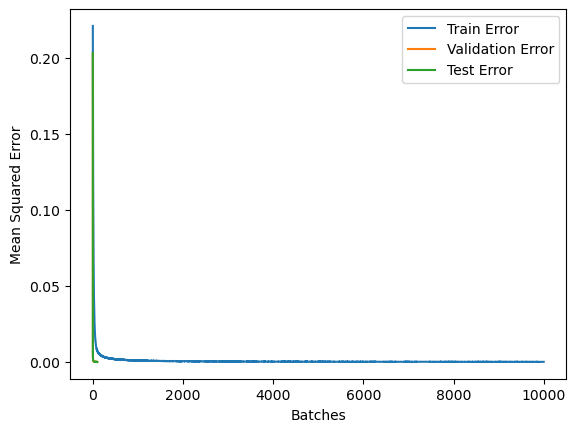

In [3]:
all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

# Hyperparameters
input_size = 45
output_size = 45
learning_rate = 0.001
final_learning_rate = 0.0001
batch_size = 1000
num_batches = 10000
num_batches_lr_reduction = 10000

# Create the neural network
model = FullyConnected4Layers(input_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data arrays
train_data = all_dwis_sh_coefficients[:60000]
train_targets = all_fODFs[:60000]
val_data = all_dwis_sh_coefficients[60000:80000]
val_targets = all_fODFs[60000:80000]
test_data = all_dwis_sh_coefficients[80000:]
test_targets = all_fODFs[80000:]

# Lists to store errors for plotting
train_errors = []
val_errors = []
test_errors = []

device = torch.device('mps')
model.to(device)

# Training loop
for batch in range(num_batches):
    
    if(batch % 1000 == 0):
        print(batch)
    
    # Adjust learning rate
    if batch == num_batches - num_batches_lr_reduction:
        for param_group in optimizer.param_groups:
            param_group['lr'] = final_learning_rate

    indices = torch.randperm(len(train_data))[:batch_size]

    inputs = torch.FloatTensor(train_data[indices])
    targets = torch.FloatTensor(train_targets[indices])
    
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_errors.append(loss.item())

    # Calculate validation and test errors
    if batch % 100 == 0:
        with torch.no_grad():
            val_inputs = torch.FloatTensor(val_data).to(device)
            val_target = torch.FloatTensor(val_targets).to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_target)
            val_errors.append(val_loss.item())

            test_inputs = torch.FloatTensor(test_data).to(device)
            test_target = torch.FloatTensor(test_targets).to(device)
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_target)
            test_errors.append(test_loss.item())

# Plot errors
plt.plot(train_errors, label='Train Error')
plt.plot(val_errors, label='Validation Error')
plt.plot(test_errors, label='Test Error')
plt.xlabel('Batches')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Save model weights
#torch.save(model.state_dict(), './model_weights.pth')


## Load data with rotations

In [34]:
all_dwis = np.load('./data/planar/rotation/diffusion_weighted_signals.npy')
all_fODFs = np.load('./data/planar/rotation/fODF_sh_coefficients.npy')
all_qhat = np.load('./data/planar/rotation/gradient_orientations.npy')
all_bvals = np.load('./data/planar/rotation/b_values.npy')
all_dwis_sh_coefficients = []

for i in range(len(all_dwis)):
    bvals, qhat, dwis = extend_dataset_with_origin_reflections(all_bvals[i], all_qhat[i], all_dwis[i])
    thetas, phis = convert_coords_from_cartesian_to_spherical(qhat)
    
    design_matrix = get_design_matrix(max_degree = 8, number_of_samples=len(dwis), thetas=thetas, phis=phis)
    spherical_fourier_transform = get_spherical_fourier_transform(design_matrix)
    expansion_coefficients = spherical_fourier_transform @ dwis
    
    all_dwis_sh_coefficients.append(expansion_coefficients)

all_dwis_sh_coefficients = np.array(all_dwis_sh_coefficients)

np.save("./data/planar/rotation/diffusion_weighted_signals_sh_coefficients", all_dwis_sh_coefficients)

In [35]:
all_dwis_sh_coefficients = np.load("./data/planar/no_rotation/diffusion_weighted_signals_sh_coefficients.npy")

In [36]:
rotated_inputs = torch.FloatTensor(all_dwis_sh_coefficients).to(device)
rotated_target = torch.FloatTensor(all_fODFs).to(device)
rotated_outputs = model(rotated_inputs)
rotated_loss = criterion(rotated_outputs, rotated_target)
rotated_loss.item()

0.06841892004013062

In [38]:
test_errors[-1]

7.341951277339831e-05

In [39]:
rotated_loss.item() / test_errors[-1]

931.8901400408158